In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LightSource, ListedColormap

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

from pathlib import Path

# Read and plot a Grainz file

C++ code

```
  std::string GRAINDATA_FILENAME)
{
  std::cout << "\n Loading graindata from the the graindata file: "
            << GRAINDATA_FILENAME << std::endl;

  // open the grain data file
  // Note that c_str() will return a const char* whereas,
  // strip function expects char*...
  std::ifstream infile(GRAINDATA_FILENAME);

  // Index coordinates
  unsigned x1=0, y1=0;

  grain_array_tot = 0;

  std::string line;

  // read a line at a time from infile
  while(std::getline(infile, line))
  {
    // check not an empty string (getline can return '' if
    // first character of line is \n or similar)

    // A string to hold each line of the text file as we iterate
    std::vector<std::string> line_vector;
    // Strip using the function in LSDStatsTools
    split_delimited_string(line, ' ', line_vector);

    unsigned col_counter = 1;
    grain_array_tot++;

    for (unsigned x=0; x<=line_vector.size()-1; x++ )
    {
      //std::cout << "LINE VECTOR IS: " << line_vector[x] << std::endl;
      if (col_counter==1) x1 = std::stoi(line_vector[x]);
      if (col_counter==2) y1 = std::stoi(line_vector[x]);

      // Prevent grains being added that are outside the grid.
      if (x1 > imax) x1 = imax;
      if (y1 > jmax) y1 = jmax;

      if (col_counter == 3)
      {
        index[x1][y1] = grain_array_tot;
      }

      // Next bunch of columns are grain fractions (surface). Update them.
      for(unsigned n=0; n<=G_MAX; n++)
      {
        if (col_counter==4+n)
        {
          grain[grain_array_tot][n] = std::stod(line_vector[x]);
        }
      }

      // Now the fractions for the subsuface strata,
      // note that this is currently hard coded as 10 layers
      // so when you update to have user-defined no. of strata, recompile
      for(int z=0; z<=9; z++)  // 9 or G_MAX-1 ?
      {
        for (unsigned n=0; n<=(G_MAX-2); n++)
        {

          if (col_counter == (4+G_MAX+n+1) + (z*9))  // 9 or G_MAX-1 ?

          {
            strata[grain_array_tot][z][n] = std::stod(line_vector[x]);
          }
        }
      }
      col_counter++; // move on to the next column (this seems really inefficient...)
    }
  }
}
```

# A python reader

In [2]:
tstep = 3600
time = tstep / 60
rainfall = 0.1
vfall = '1e-4'
print(time)

60.0


In [3]:
path_to_file = Path('/work/armitagj/runs/caesar-explore/plastics/simple-microplastic-params/')
filename = path_to_file/f'run_r{rainfall:.3f}_v{vfall}/results/Grainz{tstep}.asc'

gmax = 10
imax = 1001
jmax = 501
smax = 10
index = np.zeros((imax, jmax))
grain = np.zeros((imax, jmax, gmax))
strata = np.ones((imax, jmax, smax, gmax))

active_layer = 0.1  # active layer thickness

dprops = np.array([0, 0.3244, 0.2335, 0.2206, 0.1375, 0.0508, 0.0187, 0.0047, 0])

for i in range(imax):
    for j in range(jmax):
        for gid, dprop in enumerate(dprops):
            grain[i, j, gid] = dprop * active_layer

with open(filename) as file:

    #Index coordinates
    x1 = 0
    y1 = 0

    for line in file:
        
        line_vector = line.rstrip().split()

        y1 = int(line_vector[0]) - 1
        x1 = int(line_vector[1]) - 1

        for n in range(gmax):
            grain[x1, y1, n] = float(line_vector[4 + n])

In [4]:
x = np.linspace(0, 10e3, 1001)
y = np.linspace(0, 5e3, 501)
X, Y = np.meshgrid(x, y, indexing='ij')

In [5]:
np.shape(index)

(1001, 501)

In [6]:
active = np.zeros((imax, jmax))
for i in range(imax):
    for j in range(jmax):
        active[i, j] = np.sum(grain[i, j, :])

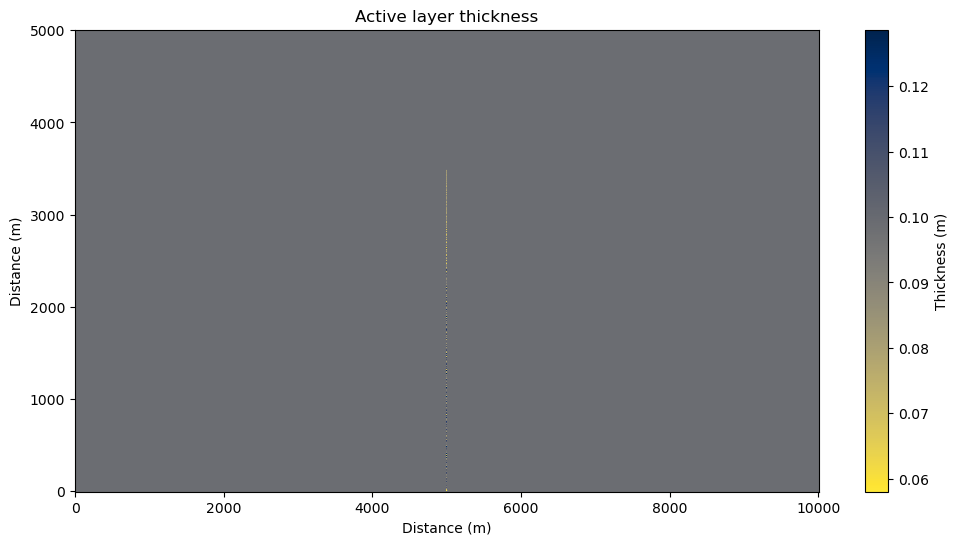

In [7]:
plt.figure(figsize=[12, 6])
plt.pcolormesh(X, Y, active, cmap='cividis_r')
plt.colorbar(label='Thickness (m)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.title('Active layer thickness')
plt.show()

In [8]:
ascfile = path_to_file/f'run_r{rainfall:.3f}_v{vfall}/results/Elevations{tstep}.asc'
ncols, nrows, geotransform, z = cp.demio.asc2numpy(str(ascfile))

z = np.flip(np.flip(z, 1), 0)
z[z == 9999] = np.nan

ll = (geotransform[0], geotransform[3] + nrows * geotransform[5])
dx = geotransform[1]

_x = np.linspace(ll[0], ll[0] + dx * (ncols -1), ncols)
_y = np.linspace(ll[1] + dx * (nrows -1), ll[1], nrows)
x, y = np.meshgrid(_x, _y, indexing='xy')

ascfile = path_to_file/f'run_r{rainfall:.3f}_v{vfall}/results/WaterDepths{tstep}.asc'
ncols, nrows, geotransform, water = cp.demio.asc2numpy(str(ascfile))
water = np.flip(np.flip(water, 1), 0)

In [9]:
# mi, ma = np.floor(np.nanmin(z)), np.ceil(np.nanmax(z))
levels = np.arange(100, 250, 25)

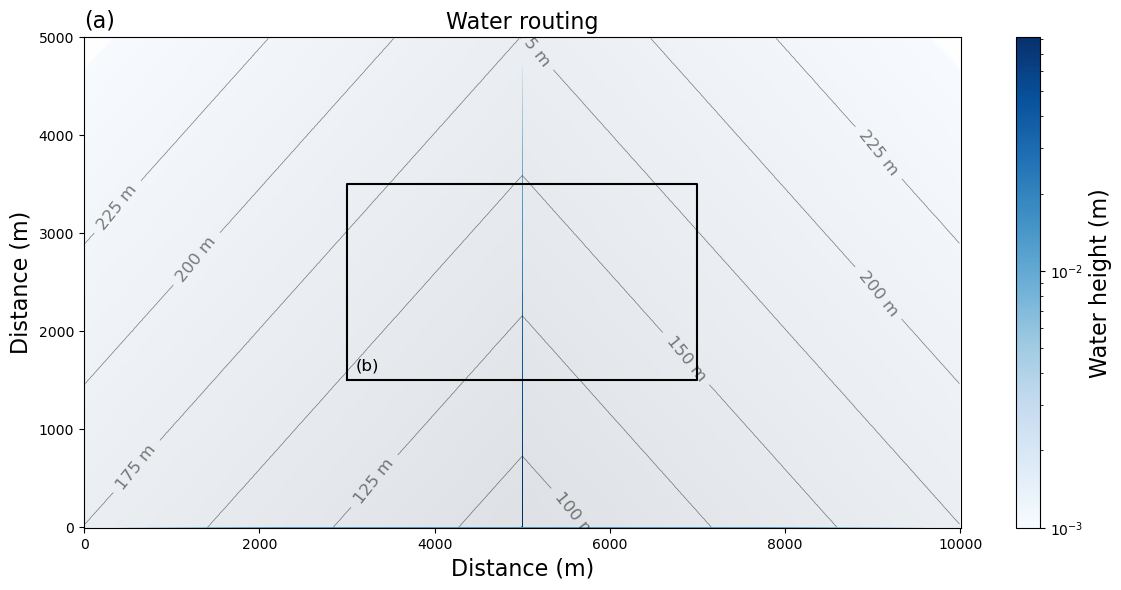

In [10]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} m" if plt.rcParams["text.usetex"] else f"{s} m"

plt.figure(figsize=[12, 6])
plt.pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-3, vmax=water.max()), cmap='Blues')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Water height (m)', fontsize=16)
plt.pcolormesh(x, y, z, cmap='gray', alpha=0.1)
cs = plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.title('Water routing', fontsize=16)
plt.text(0, 5100, '(a)', fontsize=16)
plt.plot([3000, 3000, 7000, 7000, 3000], [1500, 3500, 3500, 1500, 1500], 'k')
plt.text(3100, 1600, '(b)', fontsize=12)
plt.tight_layout()
plt.savefig(f'plots/water-routing-r{rainfall:.3f}_v{vfall}.png', dpi=300)
plt.show()

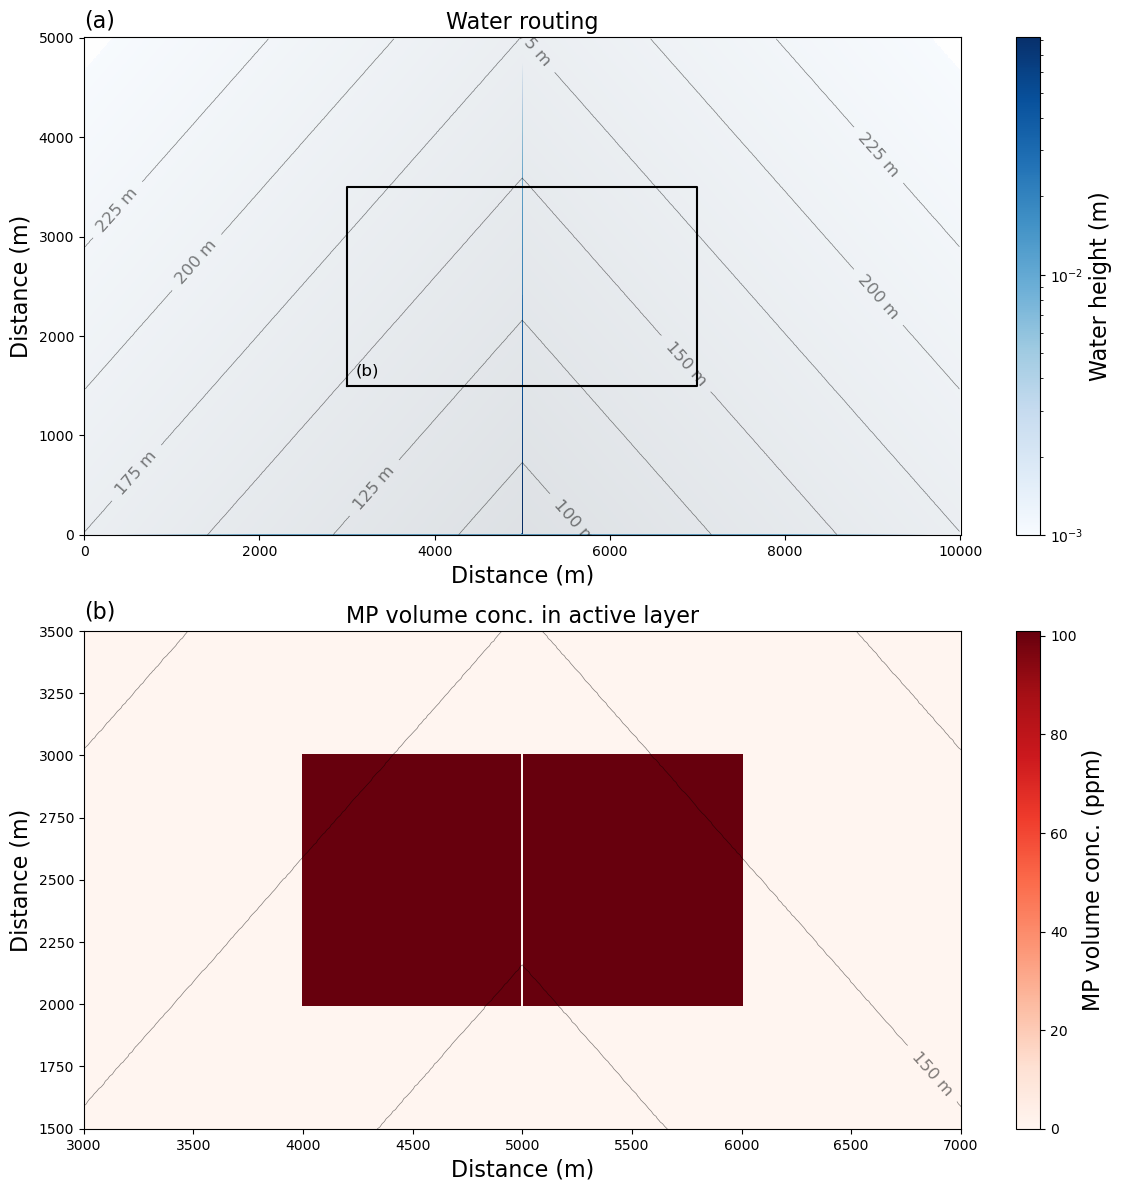

In [11]:
Z = np.divide(grain[:, :, 0], active) * 1e6

fig, axs = plt.subplots(2, figsize=[12, 12])

pcm = axs[0].pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-3, vmax=water.max()), cmap='Blues')
cbar = plt.colorbar(pcm, ax=axs[0])
cbar.ax.set_ylabel('Water height (m)', fontsize=16)
axs[0].pcolormesh(x, y, z, cmap='gray', alpha=0.1)
cs = axs[0].contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
axs[0].clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
axs[0].set_xlabel('Distance (m)', fontsize=16)
axs[0].set_ylabel('Distance (m)', fontsize=16)
axs[0].set_title('Water routing', fontsize=16)
axs[0].text(0, 5100, '(a)', fontsize=16)
axs[0].plot([3000, 3000, 7000, 7000, 3000], [1500, 3500, 3500, 1500, 1500], 'k')
axs[0].text(3100, 1600, '(b)', fontsize=12)

pcm = axs[1].pcolormesh(X, Y, Z, cmap='Reds')
axs[1].set_xlim(3000, 7000)
axs[1].set_ylim(1500, 3500)
cbar = plt.colorbar(pcm, ax=axs[1])
cbar.ax.set_ylabel('MP volume conc. (ppm)', fontsize=16)
cs = axs[1].contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
axs[1].clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
axs[1].set_xlabel('Distance (m)', fontsize=16)
axs[1].set_ylabel('Distance (m)', fontsize=16)
axs[1].set_title('MP volume conc. in active layer', fontsize=16)
axs[1].text(3000, 3550, '(b)', fontsize=16)
plt.tight_layout()
plt.savefig(f'plots/plastic-r{rainfall:.3f}_v{vfall}.png', dpi=300)
plt.show()

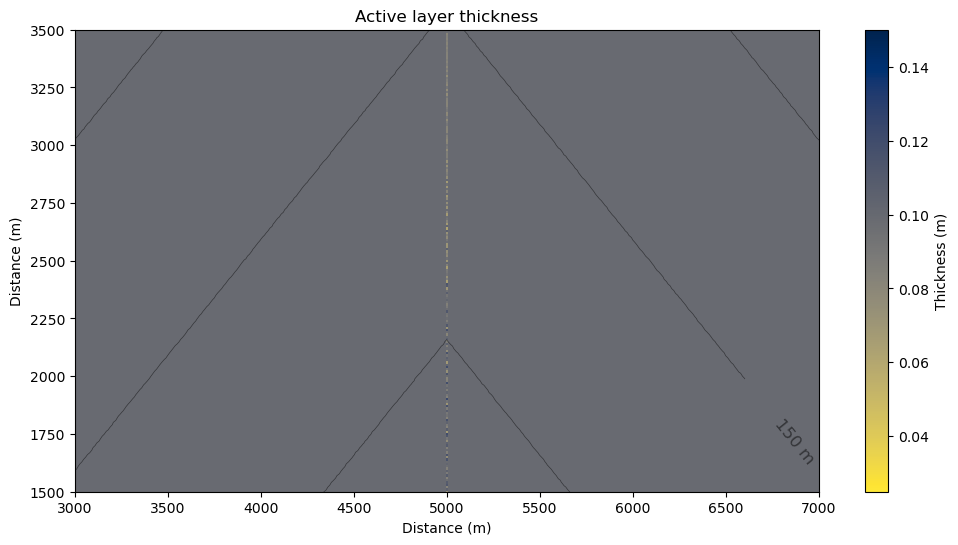

In [12]:
levels = np.arange(100, 250, 25)

plt.figure(figsize=[12, 6])
plt.pcolormesh(X, Y, active, vmin=active_layer / 4, vmax=active_layer * 1.5, cmap='cividis_r')
plt.colorbar(label='Thickness (m)')
cs = plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.title('Active layer thickness')
plt.xlim(3000, 7000)
plt.ylim(1500, 3500)
plt.savefig(f'plots/active-layer-r{rainfall:.3f}_v{vfall}.png', dpi=300)
plt.show()

In [13]:
np.shape(active)

(1001, 501)

/tmp/ipykernel_17551/3453476510.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(yy, np.nanmean(channel, axis=0), '.k')


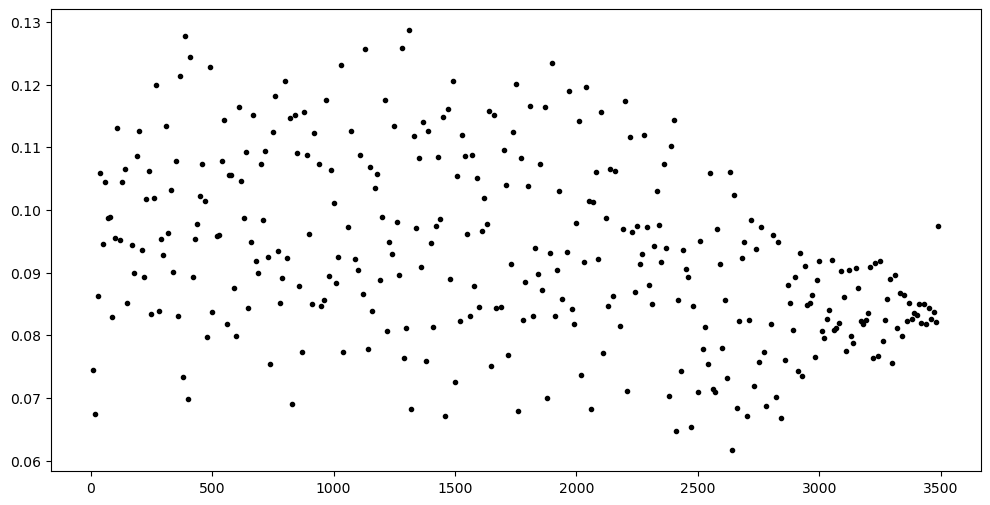

In [14]:
yy = np.linspace(0, 5e3, 501)

channel = active.copy()
channel[(active >= 0.099) & (active <= .101)] = np.nan

plt.figure(figsize=[12, 6])
plt.plot(yy, np.nanmean(channel, axis=0), '.k')
plt.show()

### Plot time series 

/tmp/ipykernel_17551/4174414594.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


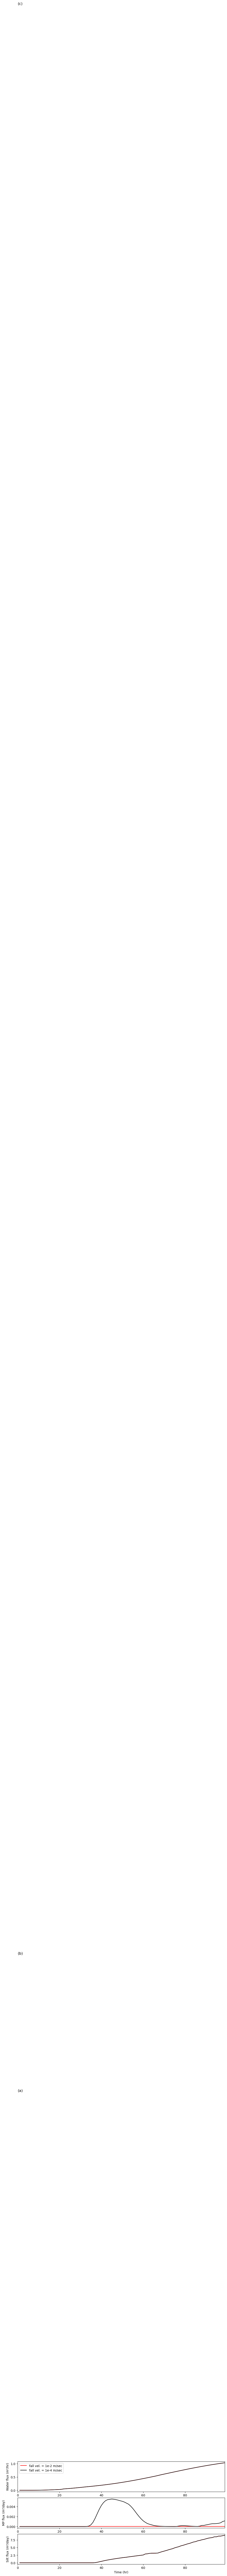

In [15]:
fg, axs = plt.subplots(3, 1, figsize=[12, 6])
vfalls = ['1e-2', '1e-4']
colours = ['r', 'k']
label = []

for i, vfall in enumerate(vfalls):

    file = path_to_file/f'run_r{rainfall:.3f}_v{vfall}/results/sedoutput.dat'
    seds_MPMWplastic = pd.read_csv(file, sep=' ', index_col=False,
                        names=['Time Step',
                               'Qw(actual)', 
                               'Qw(expected)', 
                               'Blank',
                               'Qs',
                               'plastic',
                               'silt', 
                               'very fine sand', 
                               'fine sand',
                               'medium sand',
                               'coarse sand',
                               'granulite',
                               'pebble',
                               'zeros'])
    
    density = 1330
    rock = 2660
    seds_MPMWplastic['SSC'] = seds_MPMWplastic['silt'] * density / (seds_MPMWplastic['Qw(actual)'] * 60 * 60 * 24) * 1000 # daily time step for seds

    cols_plot = ['Qw(actual)',
                 'plastic',
                 'silt']
    cols_label = ['Water flux (m³/hr)',
                  'MP flux (m³/day)',
                  'Silt flux (m³/day)']

    axs[0].plot(seds_MPMWplastic['Time Step'], seds_MPMWplastic[cols_plot[0]], color=colours[i])
    axs[0].set_ylabel(cols_label[0], fontsize=10)
    #axs[0].set_xlim(0, 650)
    
    axs[1].plot(seds_MPMWplastic['Time Step'], seds_MPMWplastic[cols_plot[1]], color=colours[i])
    axs[1].set_ylabel(cols_label[1], fontsize=10)
    #axs[1].set_xlim(0, 650)
    
    axs[2].plot(seds_MPMWplastic['Time Step'], seds_MPMWplastic[cols_plot[2]], color=colours[i])
    axs[2].set_ylabel(cols_label[2], fontsize=10)
    #axs[2].set_xlim(0, 650)

    label.append(f'fall vel. = {vfall} m/sec')

axs[0].legend(label)
axs[2].set_xlabel('Time (hr)', fontsize=10)

axs[0].text(0, 15, '(a)', fontsize=12)
axs[1].text(0, 0.115, '(b)', fontsize=12)
axs[2].text(0, 840, '(c)', fontsize=12)

for i in range(3):
    axs[i].set_xlim(0, seds_MPMWplastic['Time Step'].max())

plt.tight_layout()
plt.savefig(f'plots/plastic-flux-r{rainfall:.3f}.png', dpi=300)
plt.show()